In [242]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm 
import torch

from torch import nn, distributions
from torch.distributions import constraints
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import norm

rng = np.random.RandomState(1234)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# MCMC

Taken from PyMC tutorial here: https://www.pymc.io/projects/examples/en/latest/case_studies/stochastic_volatility.html

$\sigma \sim Exponential(10)$

$\nu \sim Exponential(.1)$

$s_i \sim Normal(s_{i-1}, \sigma^2)$

$\log(r_i) \sim t(\nu, 0, \exp(-2 s_i))$

In [91]:
try:
    returns = pd.read_csv(os.path.join("..", "data", "SP500.csv"), index_col="Date")
except FileNotFoundError:
    returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")

returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()

returns.head()


,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


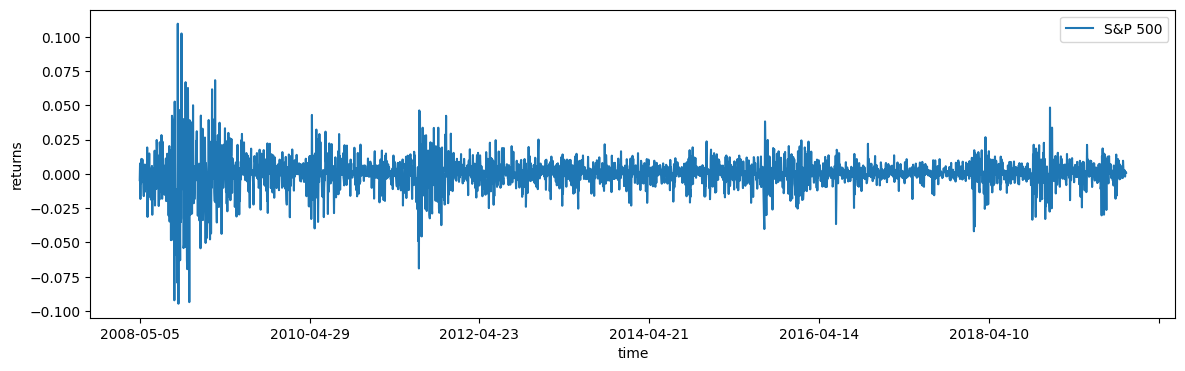

In [80]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label="S&P 500", ax=ax)
ax.set(xlabel="time", ylabel="returns")
ax.legend();

In [14]:
def make_stochastic_volatility_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, dims="time")
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT(
            "returns", nu=nu, lam=np.exp(-2 * volatility), observed=data["change"], dims="time"
        )
    return model


stochastic_vol_model = make_stochastic_volatility_model(returns)

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/pymc/distributions/timeseries.py:292: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


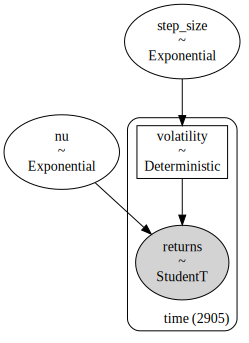

In [15]:
pm.model_to_graphviz(stochastic_vol_model)

In [16]:
with stochastic_vol_model:
    idata = pm.sample_prior_predictive(500, random_seed=rng)

prior_predictive = idata.prior_predictive.stack(pooled_chain=("chain", "draw"))


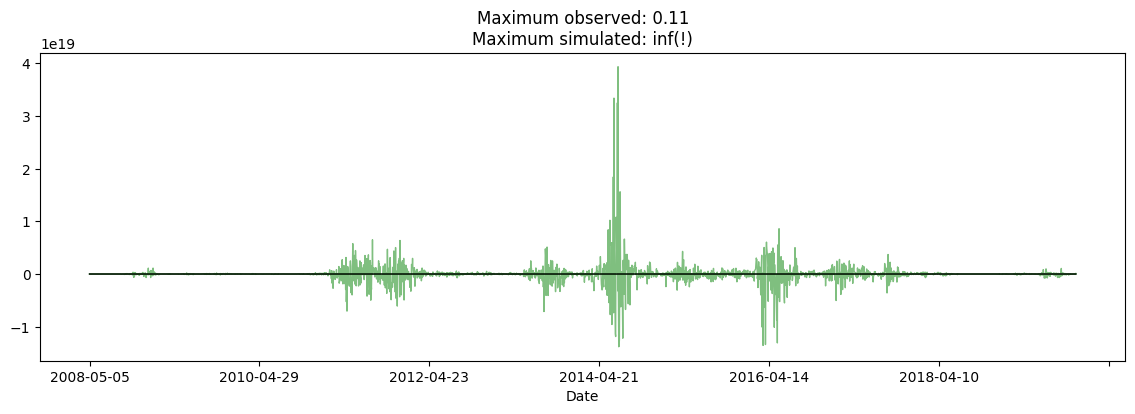

In [17]:
fig, ax = plt.subplots(figsize=(14, 4))
returns["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

In [15]:
with stochastic_vol_model:
    idata.extend(pm.sample(2000, tune=2000, random_seed=rng))

posterior = idata.posterior.stack(pooled_chain=("chain", "draw"))
posterior["exp_volatility"] = np.exp(posterior["volatility"])

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 891 seconds.
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(


In [16]:
with stochastic_vol_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

posterior_predictive = idata.posterior_predictive.stack(pooled_chain=("chain", "draw"))


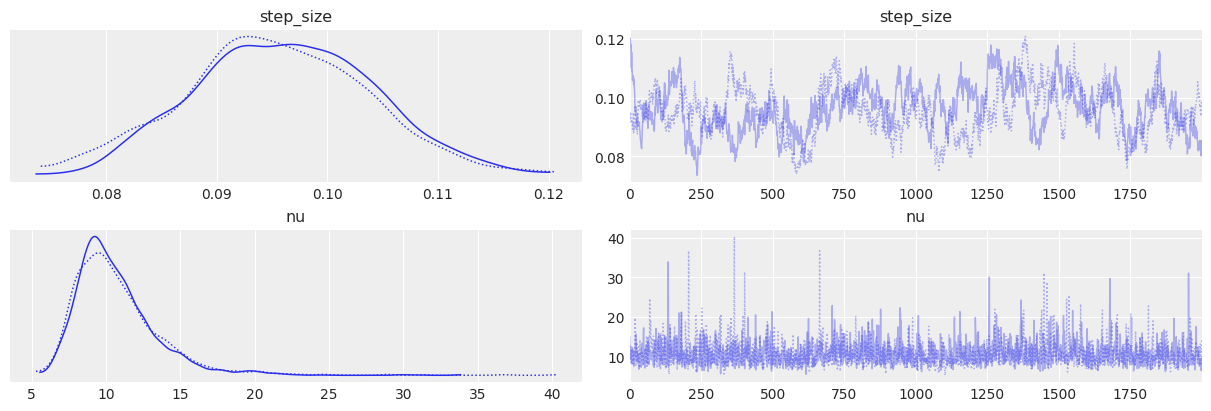

In [17]:
az.plot_trace(idata, var_names=["step_size", "nu"]);

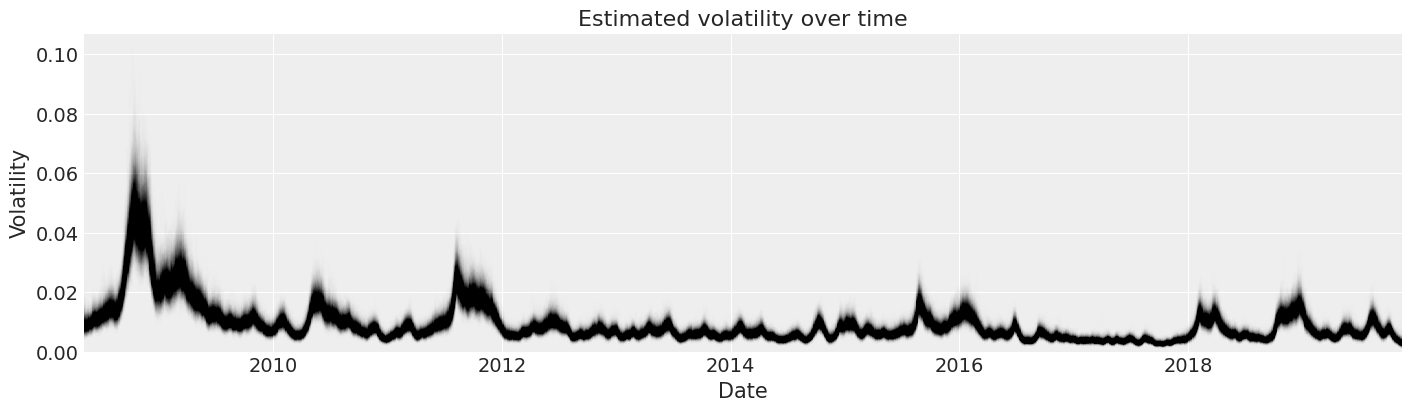

In [18]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

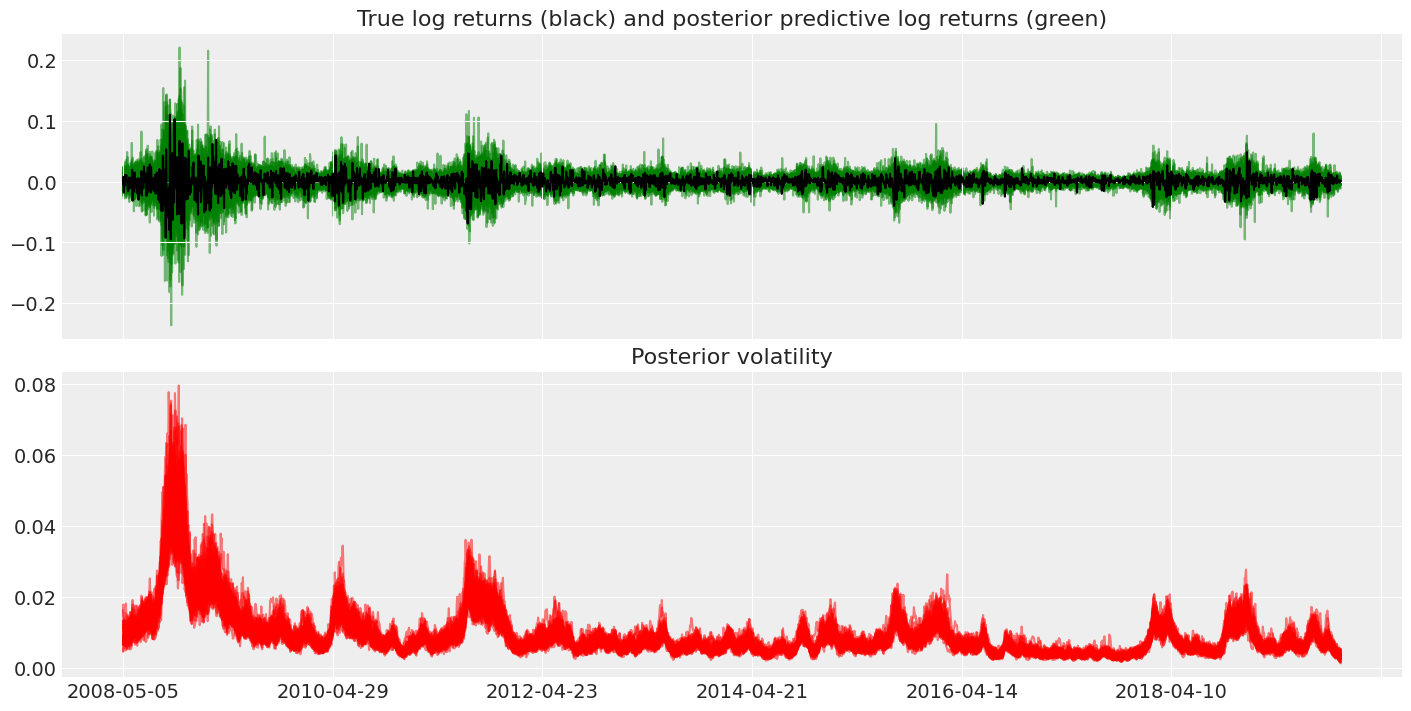

In [19]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns["change"].plot(ax=axes[0], color="black")

axes[1].plot(posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 100)), "r", alpha=0.5)
axes[0].plot(
    posterior_predictive["returns"].isel(pooled_chain=slice(None, None, 100)),
    "g",
    alpha=0.5,
    zorder=-10,
)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");

# SGLD Torch Models

$X_i = log(r_i)$

$
p(s_i, \nu, \sigma | {\bf x}) = [\Pi_ip(x_i | s_i, \nu, \sigma) p(s_i | s_{i-1}, \sigma)] p(\nu) p(\sigma)
$

In [288]:
class StochasticVolatility(nn.Module):
    def __init__(self, trace_len, sigma_lambda=1., nu_lambda=0.1):
        super(StochasticVolatility, self).__init__()
        
        self.sigma_rv = distributions.Exponential(torch.tensor(sigma_lambda))
        self.sigma = nn.Parameter(self.sigma_rv.mean)
        self.nu_rv = distributions.Exponential(torch.tensor(nu_lambda))
        self.nu = nn.Parameter(self.nu_rv.mean)
        self.vol = nn.Parameter(torch.zeros(trace_len))
      
    def returns_rv(self, vol_samples):
        # Uses \sigma parameterization, not \lambda as PyMC model above
        # See: https://en.wikipedia.org/wiki/Student%27s_t-distribution#In_terms_of_scaling_parameter_%CF%83%CC%82_or_%CF%83%CC%822
        #print(f'vol_samples={vol_samples}')
        #print(f'return_sigma={torch.exp(vol_samples)}')
        return distributions.StudentT(df=self.nu * torch.ones(vol_samples.shape), 
                                      loc=torch.zeros(vol_samples.shape), 
                                      scale=torch.exp(vol_samples))
    
    def forward(self):
        vol_samples = torch.cumsum(self.vol, dim=0)
        return self.returns_rv(vol_samples).mean, vol_samples

    def loss(self, r_obs, vol_samples):
        # Trick to prevent negative stddev
        sigma = torch.abs(self.sigma)
        
        likelihood = self.returns_rv(vol_samples).log_prob(r_obs)
       
        vol_locs = torch.cat([torch.zeros(1), vol_samples[:-1]])
        vol_rv = distributions.Normal(loc=vol_locs, scale=sigma * torch.ones(vol_locs.shape))
        vol_prior = vol_rv.log_prob(vol_samples)
       
        # Prior for each timestep
        sigma_prior = len(vol_samples) * self.sigma_rv.log_prob(sigma)
        nu_prior = len(vol_samples) * self.nu_rv.log_prob(self.nu)
        
        print(f'll = {likelihood.sum()}, vol_prior = {vol_prior.sum()}, sigma_prior = {sigma_prior}, nu_prior = {nu_prior}')
        
        return -(likelihood.sum() + vol_prior.sum() + sigma_prior + nu_prior) / len(vol_samples)

# SGLD

In [289]:
torch_data = torch.tensor(returns['change'])
torch_data, len(torch_data)

(tensor([-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
        dtype=torch.float64),
 2905)

In [292]:
torch_model = StochasticVolatility(len(torch_data), sigma_lambda=10, nu_lambda=0.1)
optimizer = optim.SGD(torch_model.parameters(), lr=0.001)
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

epoch = 0
for epoch in range(300):
    #print(f'sigma={torch_model.sigma}, nu={torch_model.nu}')
    #print(f'vol={torch_model.vol}')
    torch_model.zero_grad()
    
    r_samples, s_samples = torch_model()
    loss = torch_model.loss(torch_data, s_samples)
    loss.backward()
    print(f'sigma_grad = {torch_model.sigma.grad}, sigma = {torch_model.sigma}')
    #print(f'vol.grad = {torch_model.vol.grad}, vol = {torch_model.vol}')
    optimizer.step()
    #print(torch_model.sigma)

    # if epoch % 10 == 9:
    print(f'[epoch={epoch+1}] loss: {loss.item():.5f}')
        
for name, param in torch_model.named_parameters():
    print(f'{name} = {param}')

ll = -2742.266443228166, vol_prior = 4019.493408203125, sigma_prior = 3784.009765625, nu_prior = -9594.009765625
sigma_grad = 20.0, sigma = 0.10000000149011612
[epoch=1] loss: 1.56033
ll = 70.88278153725051, vol_prior = 4667.64990234375, sigma_prior = 4365.009765625, nu_prior = -9593.9814453125
sigma_grad = 22.499347686767578, sigma = 0.07999999821186066
[epoch=2] loss: 0.16883
ll = 2869.5001360523875, vol_prior = 5626.458984375, sigma_prior = 5018.61572265625, nu_prior = -9593.953125
sigma_grad = 27.384098052978516, sigma = 0.057500649243593216
[epoch=3] loss: -1.34961
ll = 5475.790872825904, vol_prior = 7501.00927734375, sigma_prior = 5814.12353515625, nu_prior = -9593.9248046875
sigma_grad = 43.09550476074219, sigma = 0.030116550624370575
[epoch=4] loss: -3.16592
ll = 6774.8456454284515, vol_prior = 9909.103515625, sigma_prior = 6311.97119140625, nu_prior = -9593.896484375
sigma_grad = -84.82322692871094, sigma = -0.01297895610332489
[epoch=5] loss: -4.61343
ll = 6998.39071021727, v

ll = 8793.89853879543, vol_prior = -2085.760498046875, sigma_prior = -17072.322265625, nu_prior = -9592.23828125
sigma_grad = 11.222549438476562, sigma = 0.8179460167884827
[epoch=61] loss: 6.86968
ll = 8803.504217355334, vol_prior = -2045.6279296875, sigma_prior = -16746.30859375, nu_prior = -9592.2080078125
sigma_grad = 11.239555358886719, sigma = 0.8067234754562378
[epoch=62] loss: 6.74032
ll = 8812.629773073884, vol_prior = -2004.87109375, sigma_prior = -16419.798828125, nu_prior = -9592.1787109375
sigma_grad = 11.257068634033203, sigma = 0.7954839468002319
[epoch=63] loss: 6.61075
ll = 8821.361491274045, vol_prior = -1963.469482421875, sigma_prior = -16092.78125, nu_prior = -9592.1494140625
sigma_grad = 11.27511215209961, sigma = 0.7842268943786621
[epoch=64] loss: 6.48091
ll = 8829.795669051875, vol_prior = -1921.4014892578125, sigma_prior = -15765.240234375, nu_prior = -9592.1201171875
sigma_grad = 11.293710708618164, sigma = 0.7729517817497253
[epoch=65] loss: 6.35076
ll = 8837

sigma_grad = 17.506948471069336, sigma = 0.13305597007274628
[epoch=116] loss: -1.89449
ll = 9085.085773654075, vol_prior = 3597.412109375, sigma_prior = 3332.310791015625, nu_prior = -9590.578125
sigma_grad = 18.641008377075195, sigma = 0.11554902046918869
[epoch=117] loss: -2.21144
ll = 9087.889898500334, vol_prior = 4107.5380859375, sigma_prior = 3873.83203125, nu_prior = -9590.5478515625
sigma_grad = 20.29636001586914, sigma = 0.09690801054239273
[epoch=118] loss: -2.57443
ll = 9090.640150578387, vol_prior = 4788.3076171875, sigma_prior = 4463.44140625, nu_prior = -9590.51953125
sigma_grad = 23.006669998168945, sigma = 0.07661165297031403
[epoch=119] loss: -3.01269
ll = 9093.335774236897, vol_prior = 5820.2978515625, sigma_prior = 5131.78515625, nu_prior = -9590.4892578125
sigma_grad = 28.519546508789062, sigma = 0.053604982793331146
[epoch=120] loss: -3.59894
ll = 9095.95928322132, vol_prior = 7988.3935546875, sigma_prior = 5960.2783203125, nu_prior = -9590.4599609375
sigma_grad =

sigma_grad = 10.266130447387695, sigma = 3.757554292678833
[epoch=172] loss: 37.66440
ll = 9158.674321768449, vol_prior = -6507.1181640625, sigma_prior = -102169.7109375, nu_prior = -9588.9228515625
sigma_grad = 10.26685905456543, sigma = 3.747288227081299
[epoch=173] loss: 37.55837
ll = 9160.434410518848, vol_prior = -6499.14794921875, sigma_prior = -101871.46875, nu_prior = -9588.892578125
sigma_grad = 10.267592430114746, sigma = 3.7370214462280273
[epoch=174] loss: 37.45235
ll = 9162.165009077242, vol_prior = -6491.1552734375, sigma_prior = -101573.1953125, nu_prior = -9588.86328125
sigma_grad = 10.268329620361328, sigma = 3.7267539501190186
[epoch=175] loss: 37.34632
ll = 9163.864684653641, vol_prior = -6483.140625, sigma_prior = -101274.8984375, nu_prior = -9588.8330078125
sigma_grad = 10.269070625305176, sigma = 3.7164857387542725
[epoch=176] loss: 37.24028
ll = 9165.537173717308, vol_prior = -6475.1025390625, sigma_prior = -100976.578125, nu_prior = -9588.8037109375
sigma_grad =

ll = 9226.129805509909, vol_prior = -6022.107421875, sigma_prior = -85431.09375, nu_prior = -9587.2724609375
sigma_grad = 10.315348625183105, sigma = 3.1710879802703857
[epoch=229] loss: 31.60563
ll = 9226.953809893084, vol_prior = -6012.642578125, sigma_prior = -85131.4296875, nu_prior = -9587.244140625
sigma_grad = 10.316377639770508, sigma = 3.1607725620269775
[epoch=230] loss: 31.49892
ll = 9227.766326146706, vol_prior = -6003.1455078125, sigma_prior = -84831.7421875, nu_prior = -9587.2138671875
sigma_grad = 10.317413330078125, sigma = 3.150456190109253
[epoch=231] loss: 31.39220
ll = 9228.572840727611, vol_prior = -5993.6162109375, sigma_prior = -84532.0234375, nu_prior = -9587.1845703125
sigma_grad = 10.318456649780273, sigma = 3.140138864517212
[epoch=232] loss: 31.28546
ll = 9229.370712163427, vol_prior = -5984.0546875, sigma_prior = -84232.265625, nu_prior = -9587.1552734375
sigma_grad = 10.319506645202637, sigma = 3.1298203468322754
[epoch=233] loss: 31.17869
ll = 9230.159871

[epoch=285] loss: 25.59623
ll = 9262.654343343687, vol_prior = -5424.2451171875, sigma_prior = -68295.9609375, nu_prior = -9585.5986328125
sigma_grad = 10.387409210205078, sigma = 2.581238269805908
[epoch=286] loss: 25.48818
ll = 9263.155000024519, vol_prior = -5412.53125, sigma_prior = -67994.203125, nu_prior = -9585.5693359375
sigma_grad = 10.3889741897583, sigma = 2.5708508491516113
[epoch=287] loss: 25.38009
ll = 9263.654818276473, vol_prior = -5400.76806640625, sigma_prior = -67692.40625, nu_prior = -9585.541015625
sigma_grad = 10.390552520751953, sigma = 2.5604617595672607
[epoch=288] loss: 25.27197
ll = 9264.149921019147, vol_prior = -5388.9560546875, sigma_prior = -67390.5625, nu_prior = -9585.5107421875
sigma_grad = 10.392144203186035, sigma = 2.5500712394714355
[epoch=289] loss: 25.16381
ll = 9264.639555057776, vol_prior = -5377.09326171875, sigma_prior = -67088.6640625, nu_prior = -9585.4814453125
sigma_grad = 10.39374828338623, sigma = 2.5396790504455566
[epoch=290] loss: 2

In [291]:
torch_model.vol

Parameter containing:
tensor([-1.6819e-02, -1.6787e-02, -1.6755e-02,  ..., -9.3677e-05,
        -6.3277e-05, -3.1568e-05], requires_grad=True)

In [272]:
returns['change'].tail(100).describe()

count    100.000000
mean       0.000596
std        0.008548
min       -0.030230
25%       -0.003157
50%        0.000873
75%        0.005841
max        0.018588
Name: change, dtype: float64

# 2022-10-10

* Had the modelling wrong, I need a Torch parameter for *each* latent variable in the model (not just the top level sigma/nu).  This means I need one for each step of the volatility random walk.
  * I also had a little bug with the reparameterization of t-dist from lambda to sigma (since they are inverse square of each other)
* Got it working, but... I still sometimes get negative values for \sigma since Torch doesn't care if it can eventually go negative.  I think the solution is to re-write it in terms of log(X) where X ~ exponentially distributed. See: https://math.stackexchange.com/questions/2244210/distribution-of-logx-for-exponentially-distributed-x
  * I did a hack by just taking ABS value of sigma, but that doesn't seem right.  Gradient seems off.
* Yeah the gradient of sigma gets huge after it gets close to 0, so I think I need the log parameterization or else the gradient is just going to be crazy.


TODO: 
* Use the log(X) trick to make sure \sigma doesn't go negative
* Double check logic again, sigma keeps going more negative, which is kind of odd why that would happen

# 2022-10-08

* Got the basic framework up for model in PyTorch
* Looks like $sigma$ is going negative though which causes error when used as scale for Gaussian

TODO:

* Double check the model specification, found errors in different parameterization of scales (in Normal and Gaussian)
* Also check loss function is doing what I think it should be...